In [53]:
import numpy as np
from doubleml.datasets import make_plr_CCDDHNR2018

np.random.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 20
alpha = 5.0

data = list()

for i_rep in range(n_rep):
    (x, y, d) = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    data.append((x, y, d))

In [54]:
import seaborn as sns
sns.set()

In [55]:
def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

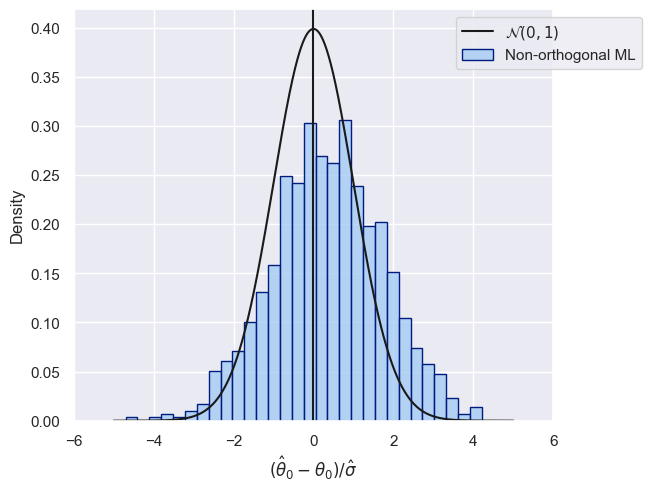

In [56]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR


from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import numpy as np
import warnings

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')

warnings.filterwarnings("ignore")

np.random.seed(1111)

ml_l = LGBMRegressor(n_estimators=30, learning_rate=0.1)
ml_m = LGBMRegressor(n_estimators=30, learning_rate=0.1)
ml_g = clone(ml_l)

theta_nonorth = np.full(n_rep, np.nan)
se_nonorth = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    
    # choose a random sample for training and estimation
    i_train, i_est = train_test_split(np.arange(n_obs), test_size=0.5, random_state=42)
    
    # fit the ML algorithms on the training sample
    ml_l.fit(x[i_train, :], y[i_train])
    ml_m.fit(x[i_train, :], d[i_train])

    l_hat = ml_l.predict(x[i_est, :])
    m_hat = ml_m.predict(x[i_est, :])

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x[i_est, :], y[i_est], d[i_est])
    obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                    ml_l, ml_m, ml_g,
                                    n_folds=2,
                                    apply_cross_fitting=False,
                                    score=non_orth_score)
    obj_dml_plr_nonorth.fit(external_predictions=external_predictions)
    theta_nonorth[i_rep] = obj_dml_plr_nonorth.coef[0]
    se_nonorth[i_rep] = obj_dml_plr_nonorth.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                color=face_colors[0], edgecolor = edge_colors[0],
                stat='density', bins=30, label='Non-orthogonal ML');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

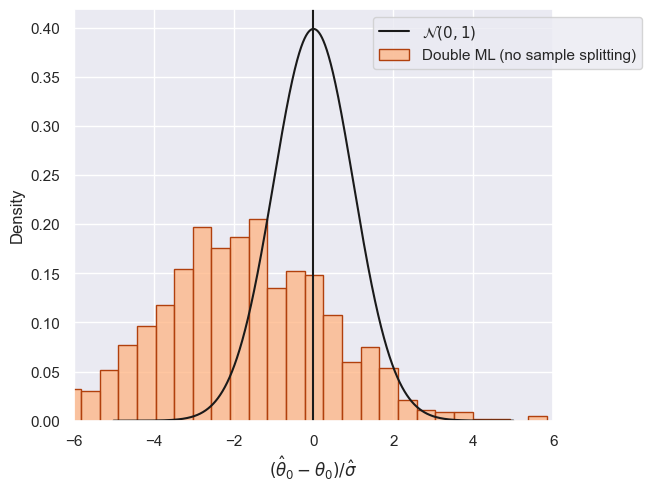

In [57]:
import numpy as np
np.random.seed(2222)

theta_orth_nosplit = np.full(n_rep, np.nan)
se_orth_nosplit = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]

    # fit the ML algorithms on the training sample
    ml_l.fit(x, y)
    ml_m.fit(x, d)

    l_hat = ml_l.predict(x)
    m_hat = ml_m.predict(x)

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    
    obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        n_folds=1,
                                        score='IV-type',
                                        apply_cross_fitting=False)
    obj_dml_plr_orth_nosplit.fit(external_predictions=external_predictions)
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
                color=face_colors[1], edgecolor = edge_colors[1],
                stat='density', bins=30, label='Double ML (no sample splitting)');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));    
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

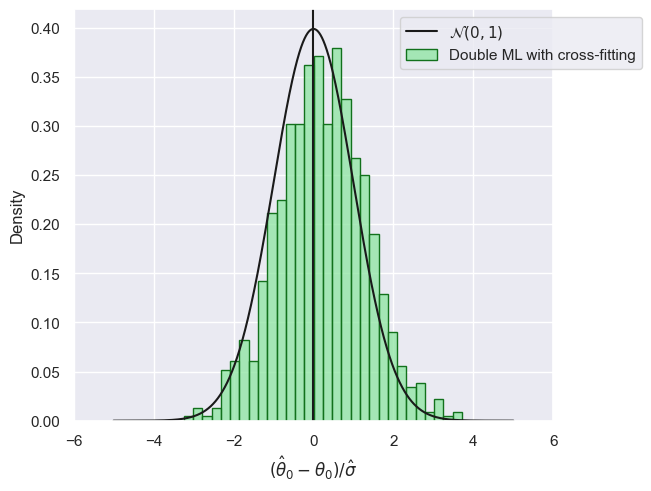

In [58]:
import numpy as np
np.random.seed(3333)

theta_dml = np.full(n_rep, np.nan)
se_dml = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr = DoubleMLPLR(obj_dml_data,
                            ml_l, ml_m, ml_g,
                            n_folds=2,
                            score='IV-type')
    obj_dml_plr.fit()
    theta_dml[i_rep] = obj_dml_plr.coef[0]
    se_dml[i_rep] = obj_dml_plr.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_dml - alpha)/se_dml,
                color=face_colors[2], edgecolor = edge_colors[2],
                stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');